# Os dados

Para coletar os dados de outros países, foram utilizadas as APIs dos sites:

- [About Corona](https://about-corona.net/dashboard/)
- [Europe RestFul](https://restcountries.eu/)

In [1]:

import requests
import pandas as pd

covid_api = 'https://corona-api.com/countries/'
rest_countries = 'https://restcountries.eu/rest/v2/alpha/'
country = 'IT' # Alpha-2 ISO3166

data_json =  requests.get(covid_api + country).json()
country = requests.get(covid_api + country).json()

N = country['data']['population']

print(country['data']['name'])


Italy


### Organizando os dados

In [2]:

from datetime import datetime

df = pd.DataFrame(data_json['data']['timeline'])
df = df.sort_values('date').reset_index()

from datetime import datetime, timedelta
df['date'] = [datetime.fromisoformat(f) for f in df['date']]
df = df.drop_duplicates(subset='date', keep = 'last')

# Criando o vetor de tempo
first_date = df['date'].iloc[0]
size_days = (df['date'].iloc[-1] - df['date'].iloc[0]).days
date_vec = [first_date + timedelta(days=k) for k in range(size_days)]

new_df = pd.DataFrame(date_vec, columns=['date'])
new_df = pd.merge(new_df, df, how='left', on= 'date')
new_df = new_df.drop(columns= ['index',  'updated_at', 'is_in_progress'])

for col in new_df.columns[1:]:
    new_df[col] = new_df[col].interpolate(method='polynomial', order=1)
df = new_df.dropna()

df.head()


,date,deaths,confirmed,active,recovered,new_confirmed,new_recovered,new_deaths
0,2020-01-30,0.0,2.000000,2.000000,0.0,2.000000,0.0,0.0
1,2020-01-31,0.0,2.000000,2.000000,0.0,0.000000,0.0,0.0
2,2020-02-01,0.0,2.142857,2.142857,0.0,0.142857,0.0,0.0
3,2020-02-02,0.0,2.285714,2.285714,0.0,0.285714,0.0,0.0
4,2020-02-03,0.0,2.428571,2.428571,0.0,0.428571,0.0,0.0


### Visualizando os dados

In [3]:
import numpy as np
from datetime import datetime

# Creating the time vector for plotly
datetime_64 = df["date"].values
ts = (datetime_64 - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
time = [datetime.utcfromtimestamp(t) for t in ts]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  


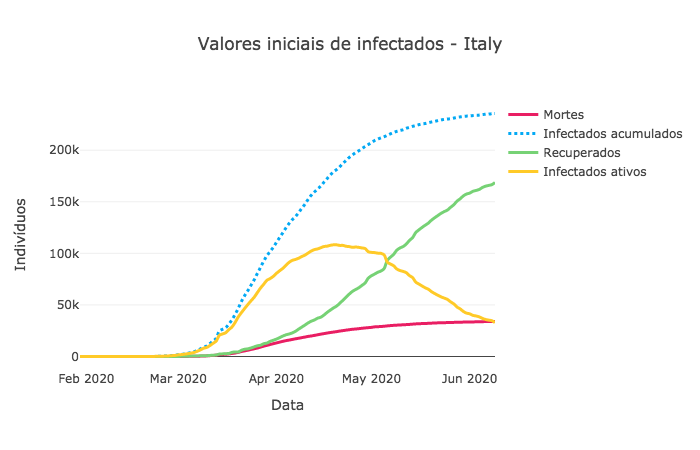

In [4]:

import plotly.graph_objects as go

first = -1

figure = go.Figure()
figure.add_trace(go.Scatter(
                    x=time[:first], 
                    y=df["deaths"].values[:first],
                    mode='lines',
                    line_shape='spline',
                    name = "Mortes",
                    line = dict(color='#e91e63', width=3)))
figure.add_trace(go.Scatter(
                    x=time[:first], 
                    y=df["confirmed"].values[:first],
                    mode='lines',
                    line_shape='spline',
                    name = "Infectados acumulados",
                    line = dict(color='#03a9f4', width=3, dash="dot")))
figure.add_trace(go.Scatter(
                    x=time[:first], 
                    y=df["recovered"].values[:first],
                    mode='lines',
                    line_shape='spline',
                    name = "Recuperados",
                    line = dict(color='#76d275', width=3)))
figure.add_trace(go.Scatter(
                    x=time[:first], 
                    y=df["active"].values[:first],
                    mode='lines',
                    line_shape='spline',
                    name = "Infectados ativos",
                    line = dict(color='#ffca28', width=3)))

figure.update_layout(template='xgridoff',
                  xaxis_title='Data',
                  yaxis_title='Indivíduos',
                  title_text="Valores iniciais de infectados - " + country['data']['name'])
# 'ggplot2', 'seaborn', 'simple_white', 'plotly',
# 'plotly_white', 'plotly_dark', 'presentation', 'xgridoff',
# 'ygridoff', 'gridon', 'none'

figure.show(renderer="png")


## Verificando os dados

Verificando se o valor acumulado dos infectados $\int I(t)$ é igual a relação aprensetada no gráfico:

In [5]:

dif_I = np.diff(df['active'])
cum = []
cum.append(dif_I[0])

for k, i in enumerate(dif_I):
    cum.append(cum[-1] + i)
    
cum = np.array(cum)
cum += df['deaths'].to_numpy() + df['recovered'].to_numpy()

print("Erro entre casos acumulados e valores de confirmados: {}".format(
        round(sum((cum - df['confirmed'].values)**2 / len(cum)),2) ) ) 


Erro entre casos acumulados e valores de confirmados: 4.0


## Encontrando o início da epidemia

Encontrando o início da epidemia para eliminar dados não informativos.

In [6]:

# Moment where cases are bigger than 2000...
start_moment = np.argmax(df["active"].to_numpy() >= 2000)


## Criando os dados SIR

In [7]:

time_ref = time[start_moment:]
I = df['active'].to_numpy()[start_moment:]
R = df['recovered'].to_numpy()[start_moment:]
M = df['deaths'].to_numpy()[start_moment:]
S = N - R - I

# Creating the time vector
t = np.linspace(0, len(I), len(I))

Sd, Id, Md, Rd, td = S, I, M, R, t


## Encontrando o pico da epidemia

Encontrando o pico da epidemia para comparações futuras.

In [8]:

from PyAstronomy import pyasl

# Compute the derivative of the smoothed 
# active infected time series
dI = np.gradient(pyasl.smooth(I, 13, "hamming"))
t = np.linspace(0, len(dI), len(dI))

# Find the derivative bigger then zero
signal = np.array([di >= 0 for di in dI[::-1]])

# Find the first point where the derivative
# change signal
peak_pos = len(Id) - np.argmax(signal)
print("O pico da epidemia aconteceu no dia {} do começo da epidemia, ou {}.".format(
    peak_pos, time_ref[peak_pos].strftime("%d %b %Y")))


O pico da epidemia aconteceu no dia 49 do começo da epidemia, ou 21 Apr 2020.


# Estimando utilizando todos os dados

In [9]:

from models import *

dataset = dict(S=Sd, I=Id, R=Rd)

# Create the model
sir_model = ss.SIR(pop=N, focus=["S", "I", "R"])

# Adjust the parameters
sir_model.fit(dataset, td,
              search_pop=True,
              pop_sens=[0.001,0.01],
              Ro_sens=[0.8, 15], 
              D_sens=[5, 60])

# Predict the model
sim_res = sir_model.predict((Sd[0],Id[0], Rd[0]), td)


Loading BokehJS ...

	 ├─ S(0) ─ I(0) ─ R(0) ─  [60337905.0, 2263.0, 160.0]
	 ├─ Ro bound ─   0.8  ─  15
	 ├─ D  bound ─   5  ─  60
	 ├─ equation weights ─   [1.660934913845834e-08, 1.5228048786709021e-05, 1.4791908175384106e-05]
	 ├─ Running on ─  differential_evolution SciPy Search Algorithm
	 └─ Defined at:  6.916497609795393  ─  41.11408931426849 



In [10]:

print("Parâmetros estimados: ", sir_model.parameters)
print("Suposto Ro: ", sir_model.parameters[0])
print("Valores de beta: {}, e r: {}".format(
    sir_model.parameters[0]/sir_model.parameters[1], 1/sir_model.parameters[1]))
print("Dias contaminados: ", sir_model.parameters[1])


Parâmetros estimados:  [6.91649761e+00 4.11140893e+01 3.19128042e-03]
Suposto Ro:  6.916497609795393
Valores de beta: 0.1682269442216503, e r: 0.024322562330304463
Dias contaminados:  41.11408931426849


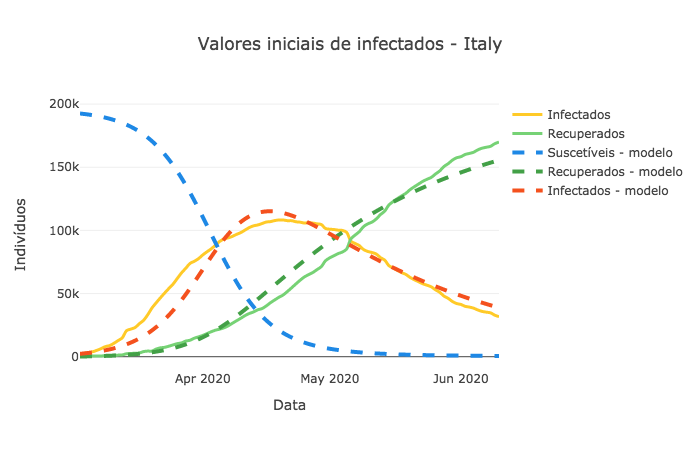

In [11]:

figure = go.Figure()
figure.add_trace(go.Scatter(
                    x=time_ref, 
                    y=I,
                    name="Infectados",
                    mode='lines',
                    line_shape='spline',
                    line = dict(color='#ffca28', width=3)))
figure.add_trace(go.Scatter(
                    x=time_ref,
                    y=R,
                    name="Recuperados",
                    mode="lines",
                    line_shape="spline",
                    line=dict(color='#76d275', width=3)))
figure.add_trace(go.Scatter(
                    x=time_ref,
                    y=sim_res[0],
                    name="Suscetíveis - modelo",
                    mode="lines",
                    line_shape="spline",
                    line=dict(color="#1e88e5", width=4, dash="dash")))
figure.add_trace(go.Scatter(
                    x=time_ref,
                    y=sim_res[2],
                    name="Recuperados - modelo",
                    mode="lines",
                    line_shape="spline",
                    line=dict(color="#43a047", width=4, dash="dash")))
figure.add_trace(go.Scatter(
                    x=time_ref,
                    y=sim_res[1],
                    name="Infectados - modelo",
                    mode="lines",
                    line_shape="spline",
                    line=dict(color="#f4511e", width=4, dash="dash")))
figure.update_layout(template='xgridoff',
                  xaxis_title='Data', yaxis_title='Indivíduos',
                  title_text="Valores iniciais de infectados - " + country['data']['name'])
# 'ggplot2', 'seaborn', 'simple_white', 'plotly',
# 'plotly_white', 'plotly_dark', 'presentation', 'xgridoff',
# 'ygridoff', 'gridon', 'none'
figure.show(renderer="png")


# Monte Carlo


Nesta parte, faremos um teste aumentando a quantidade de amostras de treinamento e prevendo o momento do pico da epidemia a medida que mais dias são utilizados para treinamento. Esse estudo vai possibilitar a análise da certeza da previsão do pico da epidemia antes desse acontecer.

In [12]:

saved_param = {'Ro':[], 'D':[], 'pop':[]}
saved_prediction = []

start_day = 8 # Starting at March 8th
pred_t = np.array(range(int(td[-1]) + 120))

for i in range(start_day, len(I)):
    # Get a partial window of the dataset
    td_ = td[:i]
    dataset = dict(S=Sd[:i], I=Id[:i], R=Rd[:i])
    # Create the model
    sir_model = ss.SIR(pop=N, focus=["S", "I", "R"], verbose=False)
    # Adjust the parameters
    sir_model.fit(dataset, td_,
                  search_pop=True,
                  pop_sens=[0.001,0.01],
                  Ro_sens=[0.8, 15], 
                  D_sens=[5, 60])
    # Save the estimated parameters
    saved_param['Ro'].append(sir_model.parameters[0])
    saved_param['D'].append(sir_model.parameters[1])
    saved_param['pop'].append(sir_model.parameters[2])
    # Save the model prediction
    saved_prediction.append(sir_model.predict((Sd[0],Id[0], Rd[0]), pred_t))
    # Print the progress...
    print("߷ Run {} of {}".format(i-start_day+1, len(I)-start_day))
    

߷ Run 1 of 92
߷ Run 2 of 92
߷ Run 3 of 92
߷ Run 4 of 92
߷ Run 5 of 92
߷ Run 6 of 92
߷ Run 7 of 92
߷ Run 8 of 92
߷ Run 9 of 92
߷ Run 10 of 92
߷ Run 11 of 92
߷ Run 12 of 92
߷ Run 13 of 92
߷ Run 14 of 92
߷ Run 15 of 92
߷ Run 16 of 92
߷ Run 17 of 92
߷ Run 18 of 92
߷ Run 19 of 92
߷ Run 20 of 92
߷ Run 21 of 92
߷ Run 22 of 92
߷ Run 23 of 92
߷ Run 24 of 92
߷ Run 25 of 92
߷ Run 26 of 92
߷ Run 27 of 92
߷ Run 28 of 92
߷ Run 29 of 92
߷ Run 30 of 92
߷ Run 31 of 92
߷ Run 32 of 92
߷ Run 33 of 92
߷ Run 34 of 92
߷ Run 35 of 92
߷ Run 36 of 92
߷ Run 37 of 92
߷ Run 38 of 92
߷ Run 39 of 92
߷ Run 40 of 92
߷ Run 41 of 92
߷ Run 42 of 92
߷ Run 43 of 92
߷ Run 44 of 92
߷ Run 45 of 92
߷ Run 46 of 92
߷ Run 47 of 92
߷ Run 48 of 92
߷ Run 49 of 92
߷ Run 50 of 92
߷ Run 51 of 92
߷ Run 52 of 92
߷ Run 53 of 92
߷ Run 54 of 92
߷ Run 55 of 92
߷ Run 56 of 92
߷ Run 57 of 92
߷ Run 58 of 92
߷ Run 59 of 92
߷ Run 60 of 92
߷ Run 61 of 92
߷ Run 62 of 92
߷ Run 63 of 92
߷ Run 64 of 92
߷ Run 65 of 92
߷ Run 66 of 92
߷ Run 67 of 92
߷ Ru

In [13]:
import pickle

with open("./Italy_mc_runs.pickle", "wb") as handle:
    pickle.dump({"pars":saved_param, "pred":saved_prediction}, handle)


# Análise do uso do sistema de saúde

Nesta análise, mostramos o erro percentual do quanto antes do pico, conseguimos prever a quantidade de pessoas que realmente serão identificadas como infectadas, uma vez que $R(\infty)$ é a quantidade de pessoas recuperadas totais, daquelas que foram noficadas como infectadas no sistema de saúde. Desta forma segue o erro proporcional do erro a medida em que novos dados diários foram incluidos no modelo:

In [ ]:

# Compute the diference of the real R(∞) with the estimated R(∞) = σ N
# and then compute the proportional difference
usage_error = [ 100 * abs(p*N - Rd[-1]) / Rd[-1] for p in saved_param['pop']]

fig = go.Figure()
fig.add_trace(go.Scatter(
                    x=time_ref[start_day:peak_pos], 
                    y=usage_error[:peak_pos-start_day],
                    mode='lines',
                    name='Antes do pico',
                    line_shape='spline',
                    line = dict(color='royalblue', width=3),
                    hovertemplate="ε(%) = %{y:.0f}, <br> no dia %{x}."))
fig.add_trace(go.Scatter(
                    x=time_ref[peak_pos:-1], 
                    y=usage_error[peak_pos-start_day:-1],
                    mode='lines',
                    line_shape='spline',
                    name='Depois do pico',
                    line = dict(color='royalblue', width=3, dash='dot'),
                    hovertemplate="ε(%) = %{y:.0f}, <br> no dia %{x}."))
fig.add_trace(go.Scatter(
                    mode="markers", 
                    x=[time_ref[peak_pos]], 
                    y=[usage_error[peak_pos-start_day]], 
                    marker_symbol="hexagram-dot", 
                    name="Momento do pico",
                    marker_line_color="midnightblue", marker_color="lightskyblue", 
                    marker_line_width=2, marker_size=15, 
                    hovertemplate="Pico no dia %{x}, com um ε(%) = %{y:.0f}."))
fig.add_trace(go.Scatter(
                    mode="markers", 
                    x=[time_ref[-1]], 
                    y=[usage_error[-1]], 
                    marker_symbol="triangle-right-dot", 
                    name="Valor atual",
                    marker_line_color="#a00037", marker_color="#ff5c8d", 
                    marker_line_width=2, marker_size=15, 
                    hovertemplate="No dia %{x}, <br> convergindo para ε(%) = %{y:.4f}."))
fig.update_layout(template='plotly_dark',#'xgridoff', 
                  yaxis_range=[-1,100],
                  legend_orientation="h", 
                  legend=dict(x=0.10, y=1.05),
                  xaxis_title='Dias (desde o começo da epidemia) utilizados para treinamento',
                  yaxis_title='Erro (%) do R(∞) - notificados',
                  title_text="Erro da previsão do uso do sistema de saúde - 🇩🇪 " + country['data']['name'])

#fig.show(renderer="png")
fig.show()


# Visualizando as previsões de $I(t)$ e $R(t)$

Vamos analisar as previsões quando somente os dados antes do pico são fornecidos ao modelo, e as previões utilizando os dados após o pico:

In [ ]:

# Create figure
fig = go.Figure()

# Add the correct trace
fig.add_trace(go.Scatter(
                x=time_ref, 
                y=I,
                name="Infectados - Dados",
                mode='lines',
                line_shape='spline',
                line = dict(color='#ffca28', width=4)))
fig.add_trace(go.Scatter(
                x=time_ref,
                y=R,
                name="Recuperados - Dados",
                mode="lines",
                line_shape="spline",
                line=dict(color='#76d275', width=3)))

# Add traces, one for each slider step
for prediction in saved_prediction:
    fig.add_trace(
        go.Scatter(
            visible=False,
            line=dict(color="#f4511d", dash="dash", width=3),
            name="Infectados - Modelo",
            x=time_ref,
            y=prediction[1]))
    fig.add_trace(
        go.Scatter(
            visible=False,
            line=dict(color="#43a047", dash="dash", width=3),
            name="Recuperados - Modelo",
            x=time_ref,
            y=prediction[2]))

for i, prediction in enumerate(saved_prediction):
    fig.add_trace(
        go.Scatter(
            mode="markers",
            visible=False,
            marker_symbol="circle", 
            name="Dia da epidemia",
            marker_color="#fb8c00", 
            marker_size=10, 
            hovertemplate="Dia da epidemia: %{x}.",
            x=[time_ref[i]], y=[I[i]]))
    fig.add_trace(
        go.Scatter(
            mode="markers",
            visible=False,
            marker_symbol="circle", 
            name="Dia da epidemia",
            marker_color="#4caf50", 
            marker_size=10, 
            hovertemplate="Dia da epidemia: %{x}.",
            x=[time_ref[i]], y=[R[i]]))
    
# Make 10th trace visible
data_size = len(saved_prediction)
fig.data[0].visible = True
fig.data[1].visible = True
fig.data[2+20].visible = True
fig.data[3+20].visible = True
fig.data[2*data_size+2+20].visible = True
fig.data[2*data_size+3+20].visible = True


# Create and add slider
steps = []
for i in range(data_size):
    step = dict(
        method='update', #"update", "relayout", "restyle"
        args=[{"visible": 2*[True] + [False]*4*data_size},
              {"title": "Slider switched to step: " + str(i)}] )
    step["args"][0]["visible"][2+2*data_size+2*i] = True
    step["args"][0]["visible"][3+2*data_size+2*i] = True
    step["args"][0]["visible"][2+2*i] = True
    step["args"][0]["visible"][3+2*i] = True
    steps.append(step)

sliders = [dict(
    active=11, pad={"t": 60}, steps=steps,
    currentvalue={"prefix": "Dia da epidemia: "},
)]

fig.update_layout(
    template='plotly_dark',#'xgridoff',
    sliders=sliders,
    xaxis_title='Data',
    yaxis_title='Indivíduos',
    title_text="Previsão do modelo para cada tempo - 🇮🇹 " + country['data']["name"],
    yaxis_range=[-5e3,max([1.30*max(I), 1.10*max(R)])],
    xaxis_range=[time_ref[0], time_ref[-1]]
)

fig.show(renderer="png")
# fig.write_html("DE_iteractive_prevision_plot.html")



# Análise de variação do $R_0$

In [ ]:


par_name = "r"

if par_name == "beta":
    plot_values = [ r_o/d for r_o, d in zip(saved_param['Ro'], saved_param['D'])]
    par_name = "β"
elif par_name == "r":
    plot_values = [ 1/d for d in saved_param['D']]
elif par_name == "Ro":
    plot_values = saved_param['Ro']

fig = go.Figure()

fig.add_trace(go.Scatter(
                    x=time_ref[start_day:peak_pos], 
                    y=plot_values[:peak_pos-start_day],
                    mode='lines',
                    name='Antes do pico',
                    line_shape='spline',
                    line = dict(color='royalblue', width=3),
                    hovertemplate=par_name+" = %{y:.4f}, <br> no dia %{x}."))
fig.add_trace(go.Scatter(
                    x=time_ref[peak_pos:-1], 
                    y=plot_values[peak_pos-start_day:-1],
                    mode='lines',
                    line_shape='spline',
                    name='Depois do pico',
                    line = dict(color='royalblue', width=3, dash='dot'),
                    hovertemplate=par_name+" = %{y:.4f}, <br> no dia %{x}."))
fig.add_trace(go.Scatter(
                    mode="markers", 
                    x=[time_ref[peak_pos]], 
                    y=[plot_values[peak_pos-start_day]], 
                    marker_symbol="hexagram-dot", name="Momento do pico",
                    marker_line_color="midnightblue", marker_color="lightskyblue", 
                    marker_line_width=2, marker_size=15, 
                    hovertemplate="Pico no dia %{x}, com um "+par_name+" = %{y:.4f}."))
fig.add_trace(go.Scatter(
                    mode="markers", 
                    x=[time_ref[-1]], 
                    y=[plot_values[-1]], 
                    marker_symbol="triangle-right-dot", name="Valor atual",
                    marker_line_color="#a00037", marker_color="#ff5c8d", 
                    marker_line_width=2, marker_size=15, 
                    hovertemplate="No dia %{x}, <br> convergindo para "+par_name+" = %{y:.4f}."))
fig.update_layout(template='xgridoff',
                  legend_orientation="h", legend=dict(x=0.10, y=1.05),
                  xaxis_title='Dias (desde o começo da epidemia) utilizados para treinamento',
                  yaxis_title='Parâmetro β',
                  title_text="Estimativa do parâmetro {} - 🇮🇹 ".format(par_name) 
                  + country['data']['name'])

fig.show(renderer="png")
# fig.show()

# Análise de confiança do pico

In [ ]:

final_day = int(td[-1])

estimated_peaks = []
for data in saved_prediction:
    # Computing the prediction derivative
    dI = np.gradient(data[1][:final_day])
    # Computing the derivative signal
    signal_pred = np.array([di >= 0 for di in dI[::-1]])
    # Computing the peak estimate point
    estimated_peaks.append(len(Id) - np.argmax(signal_pred))
estimated_peaks = np.array(estimated_peaks)


In [ ]:

# Computing the peak error in days
peak_error = np.abs(estimated_peaks - peak_pos)

fig1 = go.Figure()
fig1.add_trace(go.Scatter(
                    x=time_ref[start_day:peak_pos], 
                    y=peak_error[:peak_pos-start_day],
                    mode='lines',
                    name='Antes do pico',
                    line_shape='spline',
                    line = dict(color='royalblue', width=3),
                    hovertemplate="Erro de %{y} dias, <br> no dia %{x}."))
fig1.add_trace(go.Scatter(
                    x=time_ref[peak_pos:], 
                    y=peak_error[peak_pos-start_day:],
                    mode='lines',
                    line_shape='spline',
                    name='Depois do pico',
                    line = dict(color='royalblue', width=3, dash='dot'),
                    hovertemplate="Erro de %{y} dias, <br> no dia %{x}."))
fig1.add_trace(go.Scatter(
                    mode="markers", 
                    x=[time_ref[peak_pos]], 
                    y=[peak_error[peak_pos-start_day]], 
                    marker_symbol="hexagram-dot", name="Momento do pico",
                    marker_line_color="midnightblue", marker_color="lightskyblue", 
                    marker_line_width=2, marker_size=15, 
                    hovertemplate="Pico no dia %{x} depois do começo da epidemia."))

fig1.update_layout( template='xgridoff',
                  legend_orientation="h", legend=dict(x=0.20, y=1.0),
                  xaxis_title='Dias (desde o começo da epidemia) utilizados para treinamento',
                  yaxis_title='Erro (em dias) da estimativa do pico',
                  title_text="Erro da estimativa do pico - 🇮🇹 " + country['data']['name'])
# 'ggplot2', 'seaborn', 'simple_white', 'plotly',
# 'plotly_white', 'plotly_dark', 'presentation', 'xgridoff',
# 'ygridoff', 'gridon', 'none'

fig1.show(renderer="png")
